In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [21]:

file = pd.read_csv('../data/Inplaydata19.csv', error_bad_lines=False)
dataFrame = pd.DataFrame(file)



In [17]:
# Single, Double, Triple, HomeRun, (field_out, force_out, fielders_choice) = out, 
# grounded_into_double_play, sac_fly, sac_bunt,

#Transform values into binary classification
d = {
    'single': 1, 
    'double': 1, 
    'triple': 1, 
    'home_run': 1, 
    'field_out': 0,
    'force_out': 0,
    'fielders_choice': 1,
    'grounded_into_double_play': 0,
    'sac_fly': 0,
    'sac_bunt': 0,
    'double_play': 0,
    'fielders_choice_out': 0,
    'catcher_interf': 1,
    'triple_play': 0,
    'field_error': 1,
    'sac_fly_double_play': 0,
    'sac_bunt_double_play': 0
}

dataFrame = dataFrame.replace(d)
#dataFrame=dataFrame.sample(frac=1).reset_index(drop=True)

In [18]:
X = pd.DataFrame()
dataFrame=dataFrame[dataFrame['hc_y']!=198]
dataFrame= dataFrame.dropna(subset=['launch_speed','launch_angle','hc_x','hc_y'])
dataFrame=dataFrame.sample(frac=1).reset_index()
batterlist=dataFrame['batter']
indexlist=dataFrame['index']
X['launch_speed'] = dataFrame['launch_speed']
X['launch_angle'] = dataFrame['launch_angle']*np.pi/180
X['launch_speed_angle'] = dataFrame['launch_speed_angle']
X['estimated_ba_using_speedangle'] = dataFrame['estimated_ba_using_speedangle']
X['hc_x']=125-dataFrame['hc_x']
X['hc_y']=198-dataFrame['hc_y']
X['events'] = dataFrame['events']
X.insert(0, 'Ones', 1)


y = X['events']

X = X.iloc[:, :-1]


In [19]:
X

,Ones,launch_speed,launch_angle,launch_speed_angle,estimated_ba_using_speedangle,hc_x,hc_y
0,1,83.9,0.387463,3.0,0.355,-47.10,104.56
1,1,88.3,0.478220,3.0,0.087,79.87,98.84
2,1,106.3,0.108210,4.0,0.645,-61.09,86.49
3,1,89.7,0.111701,4.0,0.463,33.47,64.07
4,1,108.1,0.218166,5.0,0.818,-27.99,146.36
5,1,80.0,1.204277,3.0,0.000,-40.03,3.72
6,1,84.7,-0.373500,2.0,0.068,-33.86,33.24
7,1,60.6,1.069887,3.0,0.010,20.04,40.07
8,1,95.6,0.111701,4.0,0.568,-18.58,44.08
9,1,100.5,0.685914,5.0,0.171,-78.30,134.48


In [199]:
batterlist.head()

0    665742
1    600303
2    571466
3    453568
4    664040
Name: batter, dtype: int64

In [200]:


X['hor_rad']=np.arctan(X['hc_x']/X['hc_y'])
X['hor_deg']=X['hor_rad']*(180/np.pi)

In [201]:
meanspd=np.mean(X['launch_speed'])
stdspd=np.std(X['launch_speed'])
meanang=np.mean(X['launch_angle'])
stdang=np.std(X['launch_angle'])
stdhor=np.std(X['hor_rad'])


In [202]:
normX=pd.DataFrame()
normX['launch_speed']=(X['launch_speed']-meanspd)/stdspd
normX['launch_angle']=(X['launch_angle']-meanang)/stdang
normX['hor_angle']=(X['hor_rad'])/stdhor

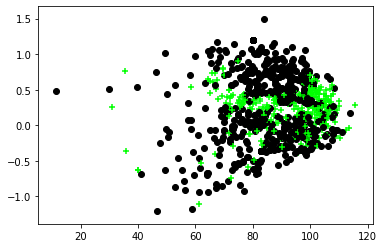

In [203]:
plt.figure()
color = [[0,0,0]]
for i in range(800):
    if y[i] == 0:
        marker="o"
        color = [[0,0,0]]
    elif y[i] == 1:
        marker="+"
        color = [[0,1,0]]
    plt.scatter(X.loc[i, 'launch_speed'], X.loc[i, 'launch_angle'], c=color, marker=marker) 
    
plt.show()


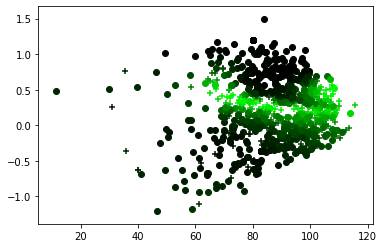

In [204]:
plt.figure()
color = [[0,0,0]]
for i in range(800):
    if y[i] == 0:
        marker="o"
        #color = [[0,0,0]]
    elif y[i] == 1:
        marker="+"
        #color = [[0,1,0]]
    
    colored= X['estimated_ba_using_speedangle'][i]
    color=[[0,colored,0]]
    plt.scatter(X.loc[i, 'launch_speed'], X.loc[i, 'launch_angle'], c=color, marker=marker) 
    
plt.show()

In [8]:
#Trim data
sliceX = normX.iloc[0:10000]
slicey = y.iloc[0:10000]

In [12]:


C = 10
rbf_svc = svm.SVC(kernel='rbf', C=C, gamma='auto')
scoresRBF = cross_val_score(rbf_svc, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scoresRBF))

ValueError: Found input variables with inconsistent numbers of samples: [999, 1000]

In [ ]:
hyperparams = { 
    'C': np.linspace(1, 100, 100),
    'gamma': np.linspace(0.00, 5, 100),
    'class_weight': ['balanced', None],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid']
}

rs = RandomizedSearchCV(svm.SVC(), hyperparams, cv=10, n_iter=25, verbose=2, scoring='accuracy')
rs.fit(sliceX, slicey)
print(rs.best_params_)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0, total=   0.8s
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0, total=   1.0s
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0 
[CV]  kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0, total=   0.7s
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0 
[CV]  kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0, total=   0.6s
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0 
[CV]  kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0, total=   1.4s
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0 
[CV]  kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0, total=   1.2s
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0 
[CV]  kernel=sigmoid, gamma=2.6262626262626263, class_weight=balanced, C=2.0, total=   1.0s
[CV] kernel=sigmoid, gamma=2.6262626262626263, class_weight=bal

In [ ]:
rbf_svc = svm.SVC(kernel='rbf', C=68, gamma=0.55, class_weight='balanced')
scoresRBF = cross_val_score(rbf_svc, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scoresRBF))

In [9]:
rf = RandomForestClassifier(n_estimators=20,n_jobs=-1,random_state=42)
scores_rf = cross_val_score(rf, sliceX, slicey, cv=10, scoring='accuracy')
print(np.mean(scores_rf))

0.8038001616001615


In [205]:
#Trim data
normX=normX.iloc[:,:3]
sliceX = normX.iloc[0:800]
slicey = y.iloc[0:800]
sliceX2 = normX.iloc[5000:10000]
slicey2 = y.iloc[5000:10000]


In [206]:
rf_hyperparams = { 
    'n_estimators': np.arange(100, 1000, 10),
    'max_features': ['auto', 'sqrt'],
    'max_depth': np.arange(10,100,10),
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'bootstrap':[True,False]
    
}
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(rf, rf_hyperparams, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(sliceX,slicey)
print(rf_random.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   45.8s finished


{'n_estimators': 570, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [208]:

bestpar = rf_random.best_params_
rf=RandomForestClassifier(n_estimators=bestpar['n_estimators'],min_samples_split=bestpar['min_samples_split'],
                         min_samples_leaf=bestpar['min_samples_leaf'],max_depth=bestpar['max_depth'],max_features=bestpar['max_features'],
                        bootstrap=bestpar['bootstrap'],n_jobs=-1, random_state=42)


In [209]:
scores_rf = cross_val_score(rf, sliceX2, slicey2, cv=10, scoring='accuracy')
classifier=rf.fit(sliceX,slicey)
print(np.mean(scores_rf))

0.806


In [210]:
results=pd.DataFrame()
predictions=classifier.predict_proba(normX)
results['launch_speed']=normX['launch_speed']*stdspd+meanspd
results['launch_angle']=normX['launch_angle']*stdang+meanang
results['predictions']=predictions[:,1]

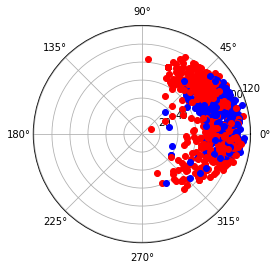

In [147]:
plt.figure()
color = [[0,0,0]]
for i in range(800):
    if y[i] == 0:
        plt.polar(X.loc[i, 'launch_angle'], X.loc[i, 'launch_speed'], 'ro')
    elif y[i] == 1:
        plt.polar(X.loc[i, 'launch_angle'], X.loc[i, 'launch_speed'], 'bo')
plt.show()

In [110]:
X.head()

,Ones,launch_speed,launch_angle,launch_speed_angle,estimated_ba_using_speedangle,hc_x,hc_y,hor_rad,hor_deg
0,1,40.0,-0.628319,1.0,0.142,2.19,6.18,0.340562,19.512745
1,1,77.8,-0.651008,2.0,0.042,10.67,37.68,0.275950,15.810748
2,1,80.6,0.619592,3.0,0.024,48.54,117.45,0.391904,22.454439
3,1,106.6,0.247837,5.0,0.740,59.99,127.42,0.440020,25.211301
4,1,86.9,0.773181,3.0,0.010,-7.50,114.60,-0.065352,-3.744384


In [111]:
sliceX.head()

,launch_speed,launch_angle,predictions
0,-3.385746,-1.754713,0.773810
1,-0.722956,-1.802110,0.067782
2,-0.525712,0.852082,0.009649
3,1.305837,0.075512,0.475414
4,-0.081913,1.172918,0.000000


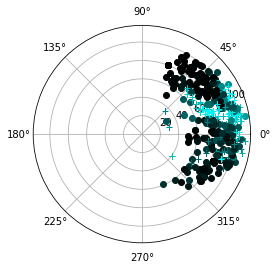

In [116]:
plt.figure()
color = [[0,0,0]]
for i in range(0,400):
    if slicey.iloc[i] == 0:
        marker='o'
    elif slicey.iloc[i] == 1:
        marker='+'
    colored=sliceX['predictions'][i]
    color=[0,colored,colored]
    plt.polar(X.loc[i, 'launch_angle'], X.loc[i, 'launch_speed'],c=color,marker=marker)
plt.show()

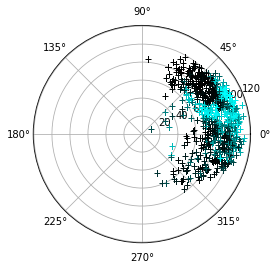

In [115]:
plt.figure()
color = [[0,0,0]]
for i in range(0,800):
    colored=sliceX['predictions'][i]
    color=[0,colored,colored]
    plt.polar(X.loc[i, 'launch_angle'], X.loc[i, 'launch_speed'],c=color,marker='+')
plt.show()

In [222]:
normX=normX.iloc[:,:3]
normX['predictions']=classifier.predict_proba(normX)[:,1]


In [228]:
#normX['batter']=batterlist
#normX['regspeed']=normX['launch_speed']*stdspd+meanspd
#normX['reglang']=normX['launch_angle']*stdang+meanang
#normX['reghang']=normX['hor_angle']*stdhor

In [235]:
pred=pd.DataFrame()
pred['batter']=normX['batter']
pred['predictions']=normX['predictions']

In [236]:
grouped=pred.groupby('batter')

In [244]:
predictor=pd.DataFrame()
#predictor['batter']=grouped.describe()['batter']
predictor['count']=grouped.describe()['predictions']['count']
predictor['exba']=grouped.describe()['predictions']['mean']
predictor=predictor.reset_index()

In [245]:

batters=pd.read_csv('../data/batterdat1.csv')
strikeouts=pd.read_csv('../data/Strikeouts.csv')
batters['Name']=batters['player_name']
full=strikeouts.merge(batters,on='Name',how='outer')
full=full.dropna()
joiner=pd.DataFrame()
joiner['batter']=full['player_id']
joiner['Name']=full['Name']
predictor=predictor.merge(joiner,on='batter',how='inner')


In [246]:
predictor.head()

,batter,count,exba,Name
0,282332,1.0,0.312589,CC Sabathia
1,400085,4.0,0.245919,Ichiro Suzuki
2,405395,431.0,0.334506,Albert Pujols
3,408234,389.0,0.342900,Miguel Cabrera
4,425772,142.0,0.337007,Jeff Mathis


In [167]:
testX=np.linspace(-3,3,40)
testy=np.linspace(-3,3,40)

In [168]:
a=[]
b=[]
for i in testX:
    for z in testy:
        a.append(i)
        b.append(z)

In [169]:
samp=pd.DataFrame()
samp['launch_speed']=a
samp['launch_angle']=b
samp['hor_angle']=0
predictionsb=classifier.predict_proba(samp)
test=pd.DataFrame()
test['predictions']=predictionsb[:,1]
test['regspeed']=samp['launch_speed']*stdspd+meanspd
test['reglang']=samp['launch_angle']*stdang+meanang

In [176]:
samp2=pd.DataFrame()
samp2['launch_speed']=a
samp2['launch_angle']=0
samp2['hor_angle']=b
predictionsb=classifier.predict_proba(samp2)
test2=pd.DataFrame()
test2['predictions']=predictionsb[:,1]
test2['regspeed']=samp2['launch_speed']*stdspd+meanspd
test2['reghang']=samp2['hor_angle']*stdhor

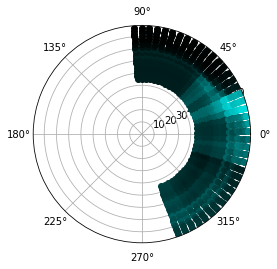

In [173]:
plt.figure()
color = [[0,0,0]]
for i in range(0,800):
    colored=test['predictions'][i]
    color=[0,colored,colored]
    plt.polar(test.loc[i, 'reglang'], test.loc[i, 'regspeed'],c=color,marker='o')
plt.show()

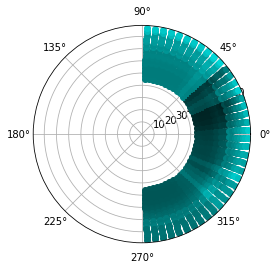

In [177]:
plt.figure()
color = [[0,0,0]]
for i in range(0,800):
    colored=test2['predictions'][i]
    color=[0,colored,colored]
    plt.polar(test2.loc[i, 'reghang'], test2.loc[i, 'regspeed'],c=color,marker='o')
plt.show()